In [4]:
x=RR['x'].gen()
x.parent()

Univariate Polynomial Ring in x over Real Field with 53 bits of precision

In [5]:
gexp=lambda p, offset: sum([x**(p*n+offset)/factorial(p*n+offset) for n in range(40)])

In [6]:
expargs = dict(xmin=-6, xmax=9, ymin=-10, ymax=600)
bndargs = dict(xmin=-16, xmax=16, ymin=-6, ymax=6)
tbndargs = dict(xmin=-1, xmax=32, ymin=-.5, ymax=.5)

#tbndargs = dict(xmin=-8, xmax=20, ymin=-2.5, ymax=2.5)

In [6]:
P=plot([
    gexp(1, 0), 
    *[gexp(2, offset) for offset in range(2)],
    *[gexp(3, offset) for offset in range(3)],
    *[gexp(4, offset) for offset in range(4)],
    *[gexp(5, offset) for offset in range(5)],
    *[gexp(6, offset) for offset in range(6)],
    *[gexp(7, offset) for offset in range(7)],
], **expargs)

P.save('multi-sub-exponential.png')

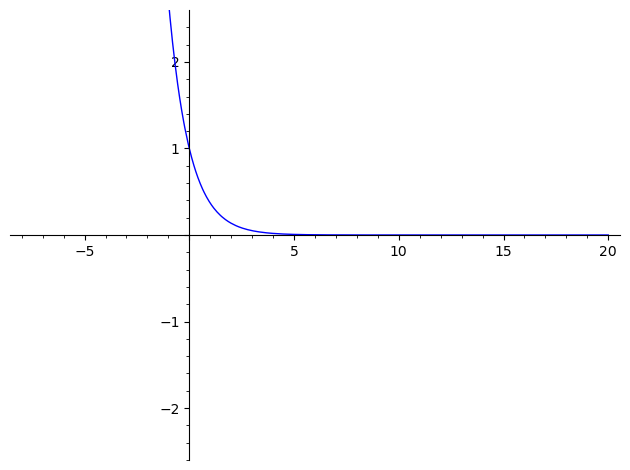

In [15]:
plot(gexp(2, 0)-gexp(2, 1), **tbndargs)

In [24]:
RR((25**80)/factorial(80))

9.56033193518996e-8

In [12]:
def hypscale(ff, factor):
    def _f(x):
        return ff(x)*exp(factor*x)
    
    return _f


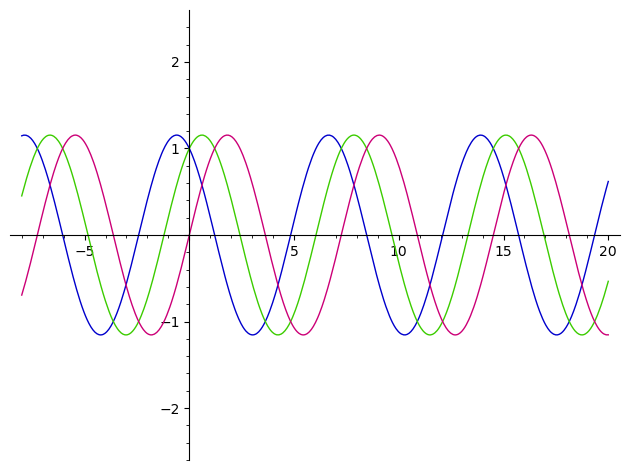

In [52]:
G3 = [gexp(3, j) for j in range(3)]
G3d = [G3[0]-G3[1], G3[0]-G3[2], G3[1]-G3[2]]
G3h=[hypscale(f, .5) for f in G3d]

tbndargs = dict(xmin=-8, xmax=20, ymin=-2.5, ymax=2.5)

P3_unscaled = plot(G3d, **tbndargs)
P3_unscaled.save('g3_family_unscaled.png')
P3_scaled = plot(G3h, **tbndargs)
P3_scaled.save('g3_family_scaled.png')
P3_scaled

In [58]:
zeros=list(find_zero_train(G3h[0]))
zeros

G3h[0](zeros[2]+(zeros[3]-zeros[2])/2)

-1.15470053819175

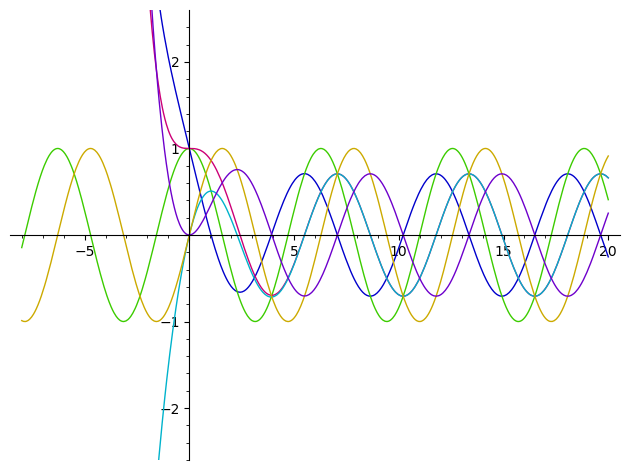

In [60]:
G4 = [gexp(4, j) for j in range(4)]
G4d = [G4[i]-G4[j] for i in range(3) for j in range(i+1, 4)]
#G3h=[hypscale(f, .5) for f in G3d]

#show(plot(G3d, **tbndargs))
P4_unscaled=plot(G4d, **tbndargs)
P4_unscaled.save('g4_family_unscaled.png')
P4_unscaled

In [64]:
zeros=list(find_zero_train(G4d[0]))
zeros

G4d[0](zeros[5]+(zeros[6]-zeros[5])/2)

0.707106787839038

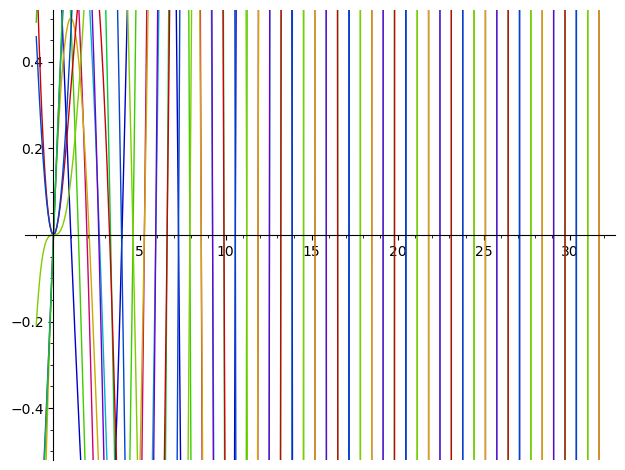

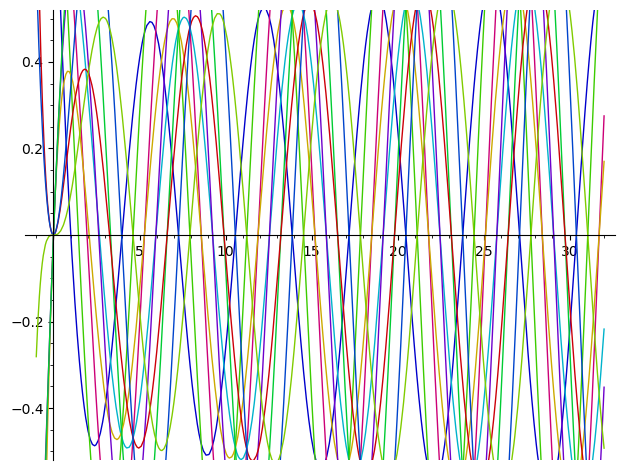

In [142]:
G4 = [gexp(5, j) for j in range(5)]
G4d = [G4[i]-G4[j] for i in range(4) for j in range(i+1, 5)]
G4h=[hypscale(f, -.3) for f in G4d]

show(plot(G4d, **tbndargs))
plot(G4h, **tbndargs)

In [34]:
WIDTH_EPS = 0.00001
ZERO_EPS = 0.0000001

def bisect(ff, xmin, xmax):
    b1 = ff(xmin)
    b2 = ff(xmax)

    if abs(b1) < ZERO_EPS:
        return xmin
    if abs(b2) < ZERO_EPS:
        return xmax

    if b1 * b2 > 0:
        raise RuntimeError(f'bisection failed {xmin} < {xmax}')

    while True and xmax-xmin > WIDTH_EPS:
        xmid = xmin + (xmax-xmin)/2
        
        #print(f'bisection progress {xmin} < {xmid} < {xmax}')
        
        bmid = ff(xmid)
        
        if abs(bmid) < ZERO_EPS:
            return xmid
        
        if xmax-xmid <= WIDTH_EPS:
            return xmid
        
        if bmid * b1 > 0:
            xmin = xmid
        elif bmid * b2 > 0:
            xmax = xmid
        else:
            raise RuntimeError(f'bisection failed {xmin} < {xmid} < {xmax}')

def find_zero_train(ff, xmax=50):
    flast = ff(1.)
    xlast = 1.
    
    if abs(flast) < ZERO_EPS:
        yield xlast

        flast = ff(1.25)
        xlast = 1.25
        
    for n in range(2, int(xmax)):
        fnext = ff(RR(n))
        xnext = RR(n)
        
        if abs(fnext) < ZERO_EPS:
            yield xnext
            
            fnext = ff(n+0.25)
            xnext = n+0.25
        elif flast * fnext < 0.:
            yield bisect(ff, xlast, xnext)

        #print(f'f({n})={round(fnext, 3)}')
            
        flast = fnext
        xlast = xnext


In [38]:

def print_diff_table(xlist):
    layer = list(xlist)
    for level in range(3):
        print((' '*5*level)+'  '.join(f'{x:8.3f}' for x in layer))
        
        if len(layer) < 2:
            break
        
        layer = [y-x for x, y in zip(layer[:-1], layer[1:])]

In [48]:
import numpy

def _find_scale_factor(f, fac_bound, xmax=50):
    zeros = list(find_zero_train(f, xmax=xmax))
    right_zeros = zeros[2:]
    
    periods = [x2-x1 for x1, x2 in zip(right_zeros[:-1], right_zeros[1:])]
    if numpy.std(periods) >= .01 or len(periods) < 5:
        raise RuntimeError('not enough zeros to find period:  '+str(zeros))
        
    period = numpy.mean(periods)
    #print(period*2)
    
    lmap = lambda func, ll: list(map(func, ll))
    
    # expect oscillation so that alternating mid-zero points are mins and maxes
    xmins = [z-period/2 for z in right_zeros[::2]]
    xmaxs = [z-period/2 for z in right_zeros[1::2]]
    ymins = lmap(f, xmins)
    ymaxs = lmap(f, xmaxs)
    if numpy.mean(ymins) > 0:
        xmins, xmaxs = xmaxs, xmins
        ymins, ymaxs = ymaxs, ymins
    if numpy.mean(ymaxs) <= 0 or numpy.mean(ymins) >= 0:
        raise RuntimeError('not detecting oscillation')

    smin = fac_bound[0]
    smax = fac_bound[1]
    for _ in range(15):
        peaks = lmap(hypscale(f, smax), xmaxs)
        if peaks[0] / peaks[-1] > 1:
            raise RuntimeError('scale factor {smax} not bounding')
        peaks = lmap(hypscale(f, smin), xmaxs)
        if peaks[0] / peaks[-1] < 1:
            raise RuntimeError('scale factor {smin} not bounding')
        
        smid = fac_bound[2](smin, smax)
        peaks = lmap(hypscale(f, smid), xmaxs)
        if peaks[0] / peaks[-1] > 1:
            smin = smid
        elif peaks[0] / peaks[-1] < 1:
            smax = smid
        else:
            # must have gotten perfectly to scaled
            break

    factor = fac_bound[2](smin, smax)
    amps = lmap(hypscale(f, factor), xmaxs)
    return factor, period*2, [numpy.mean(amps), numpy.std(amps)]

def find_scale_factor(f, xmax=50):
    return _find_scale_factor(f, (-10., -.1, lambda s1, s2: -sqrt(s1*s2)), xmax)

def find_scale_factor_3(f, xmax=50):
    return _find_scale_factor(f, (.1, 1.2, lambda s1, s2: sqrt(s1*s2)), xmax)

def find_scale_factor_4(f, xmax=50):
    zeros = list(find_zero_train(f, xmax=xmax))
    right_zeros = zeros[2:]
    
    periods = [x2-x1 for x1, x2 in zip(right_zeros[:-1], right_zeros[1:])]
    if numpy.std(periods) >= .01 or len(periods) < 5:
        raise RuntimeError('not enough zeros to find period:  '+str(zeros))
        
    period = numpy.mean(periods)
    #print(period*2)
    
    lmap = lambda func, ll: list(map(func, ll))
    
    # expect oscillation so that alternating mid-zero points are mins and maxes
    xmins = [z-period/2 for z in right_zeros[::2]]
    xmaxs = [z-period/2 for z in right_zeros[1::2]]
    ymins = lmap(f, xmins)
    ymaxs = lmap(f, xmaxs)
    if numpy.mean(ymins) > 0:
        xmins, xmaxs = xmaxs, xmins
        ymins, ymaxs = ymaxs, ymins
    if numpy.mean(ymaxs) <= 0 or numpy.mean(ymins) >= 0:
        raise RuntimeError('not detecting oscillation')

    amps = lmap(f, xmaxs)
    return None, period*2, [numpy.mean(amps), numpy.std(amps)]

In [108]:
print_diff_table(find_zero_train(G3h[2]))



   3.628     7.255    10.883    14.510    18.138    21.761    28.000    28.125    32.341    33.001    36.086    37.258    38.491    44.195    45.509    46.523    48.180
        3.628     3.628     3.628     3.628     3.623     6.239     0.126     4.216     0.660     3.085     1.172     1.233     5.704     1.314     1.014     1.657
             0.000     0.000     0.000    -0.005     2.617    -6.114     4.090    -3.555     2.424    -1.912     0.061     4.471    -4.390    -0.300     0.643


1 [0.12061411892421513, 0.0008431457739376026]
2 [0.23120470774529228, 0.0010140953897514876]
3 [0.32059752119089335, 0.0007475730228553531]
4 [0.3795553486803203, 0.00032416429442044234]
5 [0.4005810257974822, 0.0002608452161372974]
4 [0.38111065501420405, 0.0001600029749397065]
3 [0.324222946036414, 0.0001474226010624839]
2 [0.23555156945484873, 9.896655472520438e-05]
1 [0.12382548845639649, 5.4739717850871376e-05]
1 [0.12194993670299431, 0.00044031036787450887]
2 [0.2329104448745724, 0.0005331075910919968]
3 [0.3218104530378156, 0.0004242783360131003]
4 [0.379683600105541, 0.000171960598652942]
5 [0.40060458193230564, 0.00026048180248667234]
4 [0.3810551689978698, 0.0001920934230038109]
3 [0.3241546694316409, 0.00016302319460189473]
2 [0.23550656826762736, 0.00013189104172819629]
1 [0.12284919494194625, 0.00020862206408020316]
2 [0.2345338232535821, 0.00024638326409128126]
3 [0.32294701651441365, 0.0001531559271395019]
4 [0.3797373553265363, 0.00021318189411952392]
5 [0.400628019262

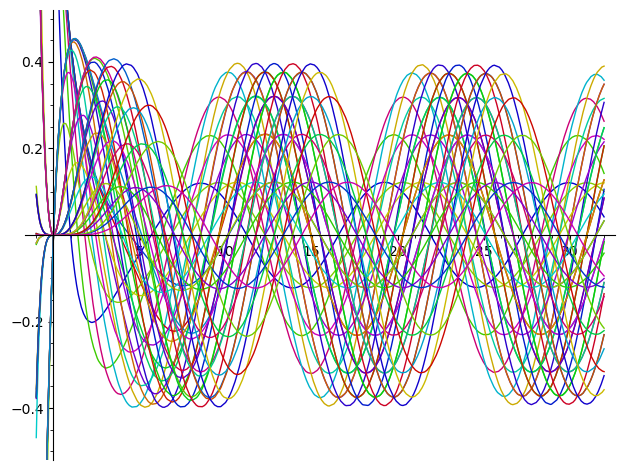

In [20]:
d=10

Gd = [gexp(d, j) for j in range(d)]
Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

scale, period, amplitude = find_scale_factor(Gdd[0])

print(scale)
#print(amplitude)

Gdh=[hypscale(f, scale) for f in Gdd]

#show(plot(Gdd, **tbndargs))
plot(Gdh, **tbndargs)

In [127]:
1/.70716

1.41410713275638

In [51]:
lines = []

d=3
Gd = [gexp(d, j) for j in range(d)]
Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

scales = []
periods = []
amplitudes = {} # bucketed by delta
for i in range(d-1):
    for j in range(i+1, d):
        diff = lambda x: exp(x)*(Gd[i](x)-Gd[j](x))

        try:
            scale, period, amplitude = find_scale_factor_3(diff, xmax=35.+d*3.)
            delta = j-i if j-i <= d/2 else i+d-j

            scales.append(scale)
            periods.append(period)
            assert amplitude[1] <= 0.01
            amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
        except RuntimeError as e:
            print(d, i, j, str(e))

amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
print(d, amps)

lines.append((d, scale, period, ''.join(amps)))


#lines.append((3, 0.5, 7.256, '??'))


d=4
Gd = [gexp(d, j) for j in range(d)]
Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

scales = []
periods = []
amplitudes = {} # bucketed by delta
for i in range(d-1):
    for j in range(i+1, d):
        diff = Gd[i]-Gd[j]

        try:
            scale, period, amplitude = find_scale_factor_4(diff, xmax=35.+d*3.)
            delta = j-i if j-i <= d/2 else i+d-j

            scales.append(scale)
            periods.append(period)
            assert amplitude[1] <= 0.01
            amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
        except RuntimeError as e:
            print(d, i, j, str(e))

amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
print(d, amps)

lines.append((d, scale, period, ''.join(amps)))


#lines.append((4, '--', r'$2\pi$', '1.000'))

for d in range(5, 13):
    Gd = [gexp(d, j) for j in range(d)]
    Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

    scales = []
    periods = []
    amplitudes = {} # bucketed by delta
    for i in range(d-1):
        for j in range(i+1, d):
            diff = Gd[i]-Gd[j]

            try:
                scale, period, amplitude = find_scale_factor(diff, xmax=35.+d*3.)
                delta = j-i if j-i <= d/2 else i+d-j

                scales.append(scale)
                periods.append(period)
                assert amplitude[1] <= 0.01
                amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
            except RuntimeError as e:
                print(d, i, j, str(e))
                
    #scale, period = find_scale_factor(Gdd[0]-Gdd[1])

    #assert numpy.std(scales) <= 0.001
    #assert numpy.std(period) <= 0.001
    #for delta in sorted(amplitudes.keys()):
    #    assert numpy.std(amplitudes[delta]) <= 0.001
        
    amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
    print(d, amps)
        
    lines.append((d, scale, period, ''.join(amps)))
    
line2 = []
for line in lines:
    if line[0] == 4:
        line2.append(line)
    else:
        line2.append((line[0], f'{line[1]:8.3f}', f'{line[2]:8.3f}', line[3]))
    
print(table(line2, header_row=['d', 'scale', 'period', 'amplitudes'], align='right', frame=True))

3 0 1 not enough zeros to find period:  [1.20920562744141, 4.83679962158203, 8.46439361572266, 12.0920028686523, 15.7195968627930, 19.3476562500000, 23.1250000000000, 25.7460937500000, 27.2187500000000, 30.5000000000000, 34.7031250000000, 35.4957199096680, 36.1250000000000, 38.2500000000000, 40.0000000000000]
3 0 2 not enough zeros to find period:  [2.41840362548828, 6.04599761962891, 9.67359161376953, 13.3012008666992, 16.9287948608398, 20.5576171875000, 26.2500000000000, 29.0000000000000, 29.9351406097412, 31.0000000000000, 32.0000000000000, 33.0000000000000, 34.0000000000000, 36.0000000000000, 37.0000000000000, 37.9947528839111, 41.0000000000000, 41.7880954742432, 43.0000000000000]
3 1 2 not enough zeros to find period:  [3.62760162353516, 7.25519561767578, 10.8827896118164, 14.5103988647461, 18.1380920410156, 21.7421875000000, 25.7500000000000, 28.4425048828125, 29.4765625000000, 34.1249389648438, 35.8437500000000, 36.6418457031250, 39.0000000000000, 39.3613281250000, 41.8750000000

In [44]:
pi

pi

In [45]:
pi.n()

3.14159265358979